In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import jax
import numpy as np
plt.style.use('science')

In [2]:
import glob
import pandas as pd

path = 'data_completa11'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = [pd.read_csv(file) for file in csv_files]

In [3]:
from utils import pre_process

In [4]:
df_preprocessed = [pre_process(df) for df in df_list]

In [5]:
df_preprocessed[0].head()

,Estacion,E,N,pm25,pm10,no2,temp,velv,hrel
date_time,,,,,,,,,
2010-01-01 00:00:00,Pudahuel,337311,6298809,10.0,25.0,13.0,16.9250,2.14056,69.0000
2010-01-01 01:00:00,Pudahuel,337311,6298809,12.0,26.0,14.0,16.0750,2.13333,73.1665
2010-01-01 02:00:00,Pudahuel,337311,6298809,12.0,26.0,16.0,15.1833,1.49166,78.1665
2010-01-01 03:00:00,Pudahuel,337311,6298809,10.0,26.0,15.0,14.6833,1.40000,81.6665
2010-01-01 04:00:00,Pudahuel,337311,6298809,10.0,25.0,13.0,14.5000,1.05000,83.5000


In [6]:
df_group=pd.concat(df_preprocessed)

In [7]:
df_group['Estacion'] = df_group['Estacion'].astype('category')    

# Model Training

In [14]:
from utils import train_test_split, create_batch_multistep

In [15]:
X_train_datasets=list()
y_train_datasets=list()
X_test_datasets=list()
y_test_datasets=list()
future=1
past=24
dataset_names=list()
for item_id, gdf in df_group.groupby('Estacion'):
    print(f"Processing station: {item_id}")
    gdf = gdf.drop(columns=['Estacion'])
    gdf = gdf.sort_index()
    feature_keys = ['pm25','pm10','no2','temp','velv','hrel']
    # Split data into training and validation sets
    train_data, val_data = train_test_split(gdf, 0.8, feature_keys)
    train_multi_feature=list()
    test_multi_feature=list()
    for feature in feature_keys:
    # Create batches for training and validation
        X_train, y_train = create_batch_multistep(train_data, lag=past, future=future,feature=feature)
        X_val, y_val = create_batch_multistep(val_data, lag=past, future=future,feature=feature)
        train_multi_feature.append(X_train)
        test_multi_feature.append(X_val)
        if feature=='pm25':
            y_train_datasets.append(y_train)
            y_test_datasets.append(y_val)
    X_train_datasets.append(np.stack(train_multi_feature,axis=-1))
    X_test_datasets.append(np.stack(test_multi_feature,axis=-1))
    dataset_names.append(item_id)
    print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")
X_train_datasets=np.stack(X_train_datasets,axis=0)
X_train_datasets=X_train_datasets.swapaxes(-1,-2)
y_train_datasets=np.stack(y_train_datasets,axis=0)
X_test_datasets=np.stack(X_test_datasets,axis=0)
X_test_datasets=X_test_datasets.swapaxes(-1,-2)
y_test_datasets=np.stack(y_test_datasets,axis=0)

/tmp/ipykernel_5272/1005800113.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for item_id, gdf in df_group.groupby('Estacion'):


Processing station: Cerrillos
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: CerroNavia
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: ElBosque
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: Independencia
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: LaFlorida
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: LasCondes
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: ParqueOhiggins
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: Pudahuel
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: PuenteAlto
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: Quilicura
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: Talagante
Train shape: (42042, 24), Validation shape: (10493, 24)


In [16]:
X_test_datasets.shape,y_test_datasets.shape

((11, 10493, 6, 24), (11, 10493, 1))

In [17]:
from utils import get_dataloader

In [ ]:
import optax
from flax import linen as nn
from functools import partial
import distrax

class LSTM(nn.Module):
    hidden_size: int
    @nn.remat    
    @nn.compact   
    def __call__(self, X_batch):
        carry,x=nn.RNN(nn.LSTMCell(self.hidden_size),return_carry=True)(X_batch)
        #carry,x=nn.RNN(nn.LSTMCell(32),return_carry=True)(x)
        #x=nn.elu(x)
        x=nn.Dense(future)(x)
        return x[:,-1,:]
    

def reparameterize(params):
    mu = params['mu_local']
    sigma = jax.tree.map(lambda p : jnp.exp(0.5*p),params['log_std_local'])
    eps = params['eps_global']
    #eps=jax.tree_map(lambda p: jax.random.normal(key=jax.random.PRNGKey(np.random.randint(42)),shape=p.shape), params['eps'])
    model_params = jax.tree.map(lambda m,e,s : m+e*s,mu,eps,sigma)
    return model_params

def log_likelihood(params, x, y):
    model_params=reparameterize(params)
    preds = jax.vmap(model.apply, (0, 0))(model_params, jnp.array(x))
    sigmas = jax.vmap(model.apply, (None, 0))(params['log_sigma_global'], jnp.array(x))
    sigmas=jax.tree.map(lambda p: jax.nn.softplus(p),sigmas)
    return -1.0*jnp.mean(distrax.Normal(preds,sigmas).log_prob(y).sum(axis=-1))

def log_prior(params):
    def prior_mu(params):
        squared=jax.tree.map(lambda p: distrax.Normal(0.0,10.0).log_prob(p).sum(), params)
        flattten_squared=jnp.sum(jnp.stack(jax.tree_util.tree_leaves(squared['params'])))
        return flattten_squared
    def prior_noise(params):
        squared=jax.tree.map(lambda p: distrax.Normal(0.0,1.0).log_prob(p).sum(), params)
        flattten_squared=jnp.sum(jnp.stack(jax.tree_util.tree_leaves(squared['params'])))
        return flattten_squared
    def prior_std(params):
        squared=jax.tree.map(lambda p: distrax.Normal(0.0,1.0).log_prob(p).sum(), params)
        flattten_squared=jnp.sum(jnp.stack(jax.tree_util.tree_leaves(squared['params'])))
        return flattten_squared
    squared_mu=prior_mu(params['mu_local'])
    squared_noise=prior_noise(params['eps_global'])
    squared_std=prior_std(params['log_std_local'])
    squared_sigma=prior_std(params['log_sigma_global'])
    return squared_std+squared_noise+squared_mu+squared_sigma

def log_post(params,batch,labels):
    n_data=batch.shape[0]
    return -1./n_data*log_prior(params) + log_likelihood(params,batch,labels)

grad_log_post=jax.jit(jax.grad(log_post))


In [20]:
@partial(jax.jit, static_argnums=(3,4))
def sgld_kernel_momemtum(key, params, momemtum,grad_log_post, dt, X, y_data):
    gamma,eps=0.9,1e-6
    key, subkey = jax.random.split(key, 2)
    grads = grad_log_post(params, X, y_data)
    grads['eps_global']=jax.tree.map(lambda p:jnp.mean(p,axis=0),grads['eps_local'])
    grads['log_sigma_global']=jax.tree.map(lambda p:jnp.mean(p,axis=0),grads['log_sigma_local'])
    squared_grads=jax.tree.map(lambda g: jnp.square(g),grads)
    momemtum=jax.tree.map(lambda m,s : gamma*m+(1-gamma)*s,momemtum,squared_grads)
    noise=jax.tree.map(lambda p: jax.random.normal(key=subkey,shape=p.shape), params)
    params=jax.tree.map(lambda p, g,m,n: p-0.5*dt*g/(m+eps)+jnp.sqrt(dt)*n, params, grads,momemtum,noise)
    return key, params,momemtum

def sgld(key,log_post, grad_log_post, num_samples,
                             dt, x_0,X_train_datasets,y_train_datasets,batch_size,
                             test_data=None):
    samples = list()
    loss=list()
    param = x_0
    key_data, key_model = jax.random.split(key, 2)
    momemtum=jax.tree.map(lambda p:jnp.zeros_like(p),param)
    key_data_batch=jax.random.split(key_data, num_samples)
    for i in range(num_samples):
        train_data=get_dataloader(X_train_datasets,y_train_datasets,batch_size,key_data_batch[i],axis=1)
        for _,(X_batch, y_batch) in enumerate(train_data):
            key_model,param,momemtum = sgld_kernel_momemtum(key_model, param,momemtum, grad_log_post, dt, X_batch, y_batch)
        loss.append(log_post(param,X_batch,y_batch))
        samples.append(param)
        if (i%(num_samples//10)==0):
            print('iteration {0}, loss {1:.2f}'.format(i,loss[-1]))
    return samples,loss

In [21]:
key=jax.random.PRNGKey(0)
key_model,key_data=jax.random.split(key,2)
batch_size=256

In [159]:
model=LSTM()
n_groups=X_train_datasets.shape[0]
n_features=len(feature_keys)
inputs = jax.random.randint(key,(batch_size,n_features,past),0, 10,).astype(jnp.float32)



In [160]:
inputs.shape

(256, 6, 24)

In [161]:
X_train_datasets.shape,y_train_datasets.shape

((11, 42042, 6, 24), (11, 42042, 1))

In [162]:
key_model_init, key_state_init = jax.random.split(key_model, 2)
key_params_mu,key_params_sigma,key_params_eps,key_params_aleatoric=jax.random.split(key_model_init,4)

key_tasks_mu=jax.random.split(key_params_mu,n_groups)

key_params_sigma_local,key_params_sigma_global=jax.random.split(key_params_sigma,2)
key_tasks_sigma=jax.random.split(key_params_sigma_local,n_groups)

key_params_aleatoric_local,key_params_aleatoric_global=jax.random.split(key_params_aleatoric,2)
key_tasks_aleatoric=jax.random.split(key_params_aleatoric_local,n_groups)
key_noise_local,key_noise_global=jax.random.split(key_params_eps,2)
key_tasks_noise=jax.random.split(key_noise_local,n_groups)

params_noise_local = jax.vmap(model.init, (0, None))(key_tasks_noise, inputs)
params_noise=model.init(key_noise_global,inputs)
params_mu=jax.vmap(model.init, (0, None))(key_tasks_mu, inputs)
params_sigma=jax.vmap(model.init, (0, None))(key_tasks_sigma, inputs)

params_aleatoric=model.init(key_params_aleatoric_global,inputs)
params_aleatoric_local=jax.vmap(model.init, (0, None))(key_tasks_aleatoric, inputs)
#jax.tree_map(lambda p: distrax.Normal(0.0,1.0).sample(seed=key_params_sigma,sample_shape=(1,)),params_mu)


params_pooled = {
    'mu_local': params_mu,
    'log_std_local': params_sigma,
    'eps_global': params_noise,
    'eps_local': params_noise_local,
    'log_sigma_global': params_aleatoric,
    'log_sigma_local': params_aleatoric_local
}
model_params=reparameterize(params_pooled)

In [163]:
params_pooled.keys()

dict_keys(['mu_local', 'log_std_local', 'eps_global', 'eps_local', 'log_sigma_global', 'log_sigma_local'])

In [164]:
log_prior(params_pooled)

Array(-417583.66, dtype=float32)

In [165]:
log_likelihood(params_pooled, X_train_datasets[:,:32,:,:], y_train_datasets[:,:32,:])

Array(1.05736, dtype=float32)

In [166]:
model_params=reparameterize(params_pooled)
batch_inputs = jax.random.randint(key,(batch_size,n_features,past),0, 10,).astype(jnp.float32)
preds = jax.vmap(model.apply, (0, None))(model_params, batch_inputs)

In [167]:
preds.shape

(11, 256, 1)

In [168]:
dt=1e-5
samples,loss=sgld(key_data,log_likelihood, grad_log_post, 100,
                             dt, params_pooled,X_train_datasets,y_train_datasets,
                             batch_size,test_data=None)

iteration 0, loss 0.84
iteration 10, loss 0.81
iteration 20, loss 0.57
iteration 30, loss 0.58
iteration 40, loss 0.67
iteration 50, loss 0.61
iteration 60, loss 0.93
iteration 70, loss 0.68
iteration 80, loss 0.60
iteration 90, loss 0.69


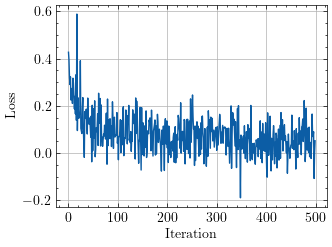

In [70]:
fig, ax = plt.subplots()
pparam = dict(xlabel="Iteration", ylabel=r"Loss")
ax.plot(loss)
ax.set(**pparam)
ax.grid(True)
plt.savefig('multi_site_loss.pdf', bbox_inches='tight',dpi=300)
plt.show()

In [54]:
X_test=X_test_datasets
model_params=reparameterize(samples[-1])
preds=jax.vmap(model.apply, (0, 0))(model_params, X_test)

In [55]:
preds.shape

(11, 10493, 1)

In [28]:
import pickle

with open('federated_sgld.samples', 'wb') as samples_file:
    pickle.dump(samples, samples_file)

# MCMC Model Diagnostics



In [29]:
import pickle
with open('federated_sgld.samples', 'rb') as samples_file:
    samples = pickle.load(samples_file)

In [30]:
reshaper = lambda s : jax.tree.map(lambda p : p.reshape((n_groups,-1)),s)

flat_params=list()
for s in samples:
    flat_sample=reshaper(s['mu'])['params']
    flat_sample=(jax.tree_util.tree_flatten(flat_sample)[0])
    flat_sample=jnp.concatenate(flat_sample,axis=-1)
    flat_params.append(flat_sample)
flat_params=jnp.stack(flat_params,axis=1)

In [31]:
import tensorflow_probability as tfp


In [32]:
import tensorflow_probability as tfp

ess_list=list()

for g in flat_params:
    ess = tfp.mcmc.effective_sample_size(g, filter_beyond_positive_pairs=True)
    ess_list.append(ess.numpy())
ess_list=jnp.stack(ess_list)

/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/tensorflow_probability/python/__init__.py:70: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  warnings.warn(


2025-06-19 12:12:12.713943: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


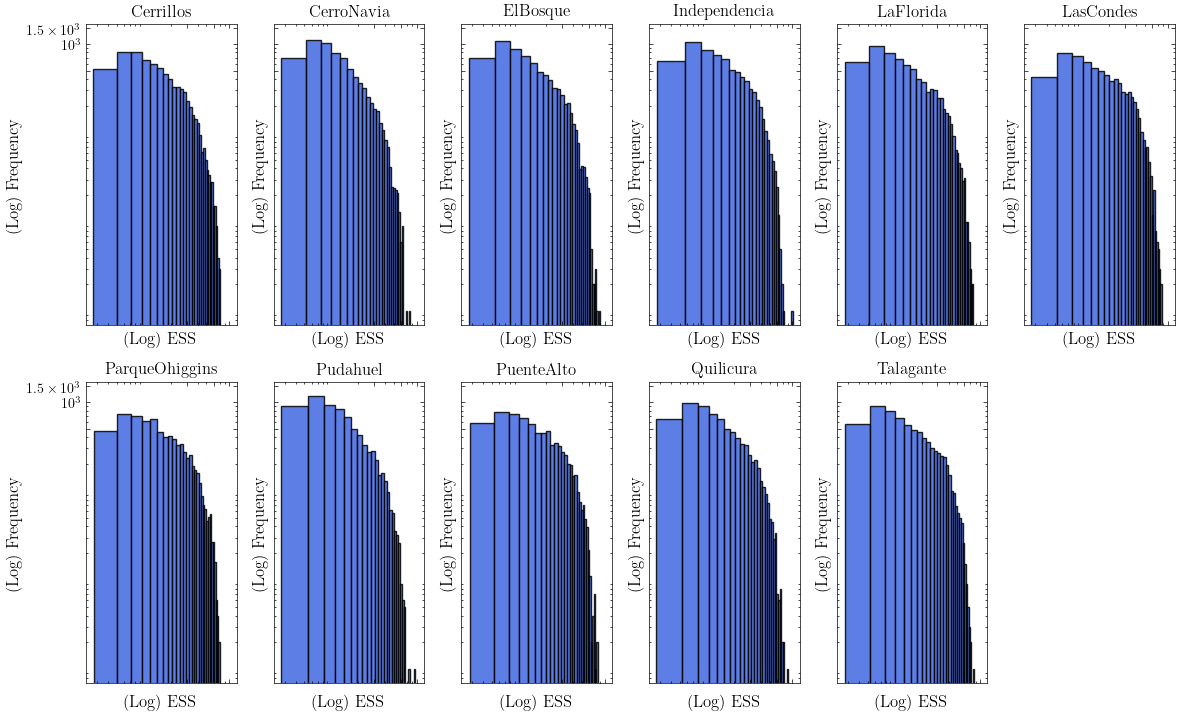

In [33]:
import matplotlib.ticker as mticker

fig, axes = plt.subplots(2, 6, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, ess in enumerate(ess_list):
    axes[i].hist(ess, bins=30, color='royalblue', alpha=0.85, edgecolor='black')
    axes[i].set_title(dataset_names[i], fontsize=12)
    axes[i].set_yscale('log')
    axes[i].set_xscale('log')
    #axes[i].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    axes[i].set_xlabel("(Log) ESS", fontsize=12)
    axes[i].set_ylabel("(Log) Frequency", fontsize=12)
    axes[i].xaxis.set_major_locator(mticker.MaxNLocator(4))
    axes[i].yaxis.set_major_locator(mticker.MaxNLocator(4))

# Hide unused subplots if any
for j in range(i+1, len(axes)):
    axes[j].axis('off')

#fig.suptitle("Effective Sample Size (ESS) per Station", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('multi_site_ess.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Posterior Predictive

In [169]:
X_test=X_test_datasets
params=reparameterize(samples[-1])
preds=jax.vmap(model.apply, (0, 0))(params, X_test)

In [170]:
from sklearn import metrics
r_metric=list()
rmse_metric=list()
mae_metric=list()
for i in range(n_groups):
    r_squared=metrics.r2_score(preds[i,:,:],y_test_datasets[i,:,:])
    rmse=metrics.mean_squared_error(preds[i,:,:],y_test_datasets[i,:,:])
    mae=metrics.mean_absolute_error(preds[i,:,:],y_test_datasets[i,:,:])
    r_metric.append(r_squared)
    rmse_metric.append(rmse)
    mae_metric.append(mae)
    print('task : {0}, RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse,mae,r_squared))
print('-------------------------------------------------------')
print('RMSE : {0:1.2f}, MAE :{1:1.2f}, R2 :{2:1.2f}'.format(np.mean(rmse_metric),np.mean(mae_metric),np.mean(r_metric)))

task : Cerrillos, RMSE : 0.30, MAE :0.40, R2 :0.78
task : CerroNavia, RMSE : 0.12, MAE :0.24, R2 :0.84
task : ElBosque, RMSE : 0.22, MAE :0.30, R2 :0.71
task : Independencia, RMSE : 0.27, MAE :0.35, R2 :0.73
task : LaFlorida, RMSE : 0.25, MAE :0.34, R2 :0.79
task : LasCondes, RMSE : 0.29, MAE :0.38, R2 :0.72
task : ParqueOhiggins, RMSE : 0.27, MAE :0.36, R2 :0.79
task : Pudahuel, RMSE : 0.20, MAE :0.29, R2 :0.73
task : PuenteAlto, RMSE : 0.24, MAE :0.33, R2 :0.69
task : Quilicura, RMSE : 0.24, MAE :0.32, R2 :0.77
task : Talagante, RMSE : 0.30, MAE :0.37, R2 :0.63
-------------------------------------------------------
RMSE : 0.24, MAE :0.33, R2 :0.74


In [118]:
ensemble_pred=list()
X_test=X_test_datasets
r_metric={i: [] for i in range(n_groups)}
rmse_metric={i: [] for i in range(n_groups)}
mae_metric={i: [] for i in range(n_groups)}
for j in range(len(samples)):
    params=reparameterize(samples[j])
    preds=jax.vmap(model.apply, (0, 0))(params, X_test)
    ensemble_pred.append(preds)
    for i in range(n_groups):
        r_squared=metrics.r2_score(preds[i,:,:],y_test_datasets[i,:,:])
        rmse=metrics.mean_squared_error(preds[i,:,:],y_test_datasets[i,:,:])
        mae=metrics.mean_absolute_error(preds[i,:,:],y_test_datasets[i,:,:])
        r_metric[i].append(r_squared)
        rmse_metric[i].append(rmse)
        mae_metric[i].append(mae)
    #print('task : {0}, RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse,mae,r_squared))
#print('-------------------------------------------------------')
#print('RMSE : {0:1.2f}, MAE :{1:1.2f}, R2 :{2:1.2f}'.format(np.mean(rmse_metric),np.mean(mae_metric),np.mean(r_metric)))

In [119]:
ensemble_pred=np.stack(ensemble_pred,axis=-1)

In [120]:
mean_pred=np.mean(ensemble_pred,axis=-1)
std_pred=np.std(ensemble_pred,axis=-1)

In [121]:
np.mean(mae_metric[0]),2*np.std(mae_metric[0])

(0.36813523185355934, 0.021153371010018688)

In [122]:
for i in range(n_groups):
    r_squared=np.mean(r_metric[i]),2*np.std(r_metric[i])
    rmse=np.mean(rmse_metric[i]),2*np.std(rmse_metric[i])
    mae=np.mean(mae_metric[i]),2*np.std(mae_metric[i])
    print('task : {0}, Mean RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse[0],mae[0],r_squared[0]))
    print('task : {0}, Error RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse[1],mae[1],r_squared[1]))
    print('-------------------------------------------------------')
mean_mae,error_mae=np.concatenate([mae_metric[i] for i in range(n_groups)]).mean(),2*np.concatenate([mae_metric[i] for i in range(n_groups)]).std()
mean_r,error_r=np.concatenate([r_metric[i] for i in range(n_groups)]).mean(),2*np.concatenate([r_metric[i] for i in range(n_groups)]).std()
mean_rmse,error_rmse=np.concatenate([rmse_metric[i] for i in range(n_groups)]).mean(),2*np.concatenate([rmse_metric[i] for i in range(n_groups)]).std()
print('Mean RMSE : {0:1.2f}, MAE :{1:1.2f}, R2 :{2:1.2f}'.format(mean_rmse,mean_mae,mean_r))
print('Eror RMSE : {0:1.2f}, MAE :{1:1.2f}, R2 :{2:1.2f}'.format(error_rmse,error_mae,error_r))

task : Cerrillos, Mean RMSE : 0.30, MAE :0.37, R2 :0.66
task : Cerrillos, Error RMSE : 0.04, MAE :0.02, R2 :0.12
-------------------------------------------------------
task : CerroNavia, Mean RMSE : 0.17, MAE :0.26, R2 :0.75
task : CerroNavia, Error RMSE : 0.05, MAE :0.03, R2 :0.16
-------------------------------------------------------
task : ElBosque, Mean RMSE : 0.25, MAE :0.33, R2 :0.69
task : ElBosque, Error RMSE : 0.04, MAE :0.03, R2 :0.10
-------------------------------------------------------
task : Independencia, Mean RMSE : 0.32, MAE :0.38, R2 :0.66
task : Independencia, Error RMSE : 0.08, MAE :0.04, R2 :0.18
-------------------------------------------------------
task : LaFlorida, Mean RMSE : 0.30, MAE :0.36, R2 :0.65
task : LaFlorida, Error RMSE : 0.03, MAE :0.02, R2 :0.09
-------------------------------------------------------
task : LasCondes, Mean RMSE : 0.39, MAE :0.43, R2 :0.47
task : LasCondes, Error RMSE : 0.07, MAE :0.03, R2 :0.18
----------------------------------

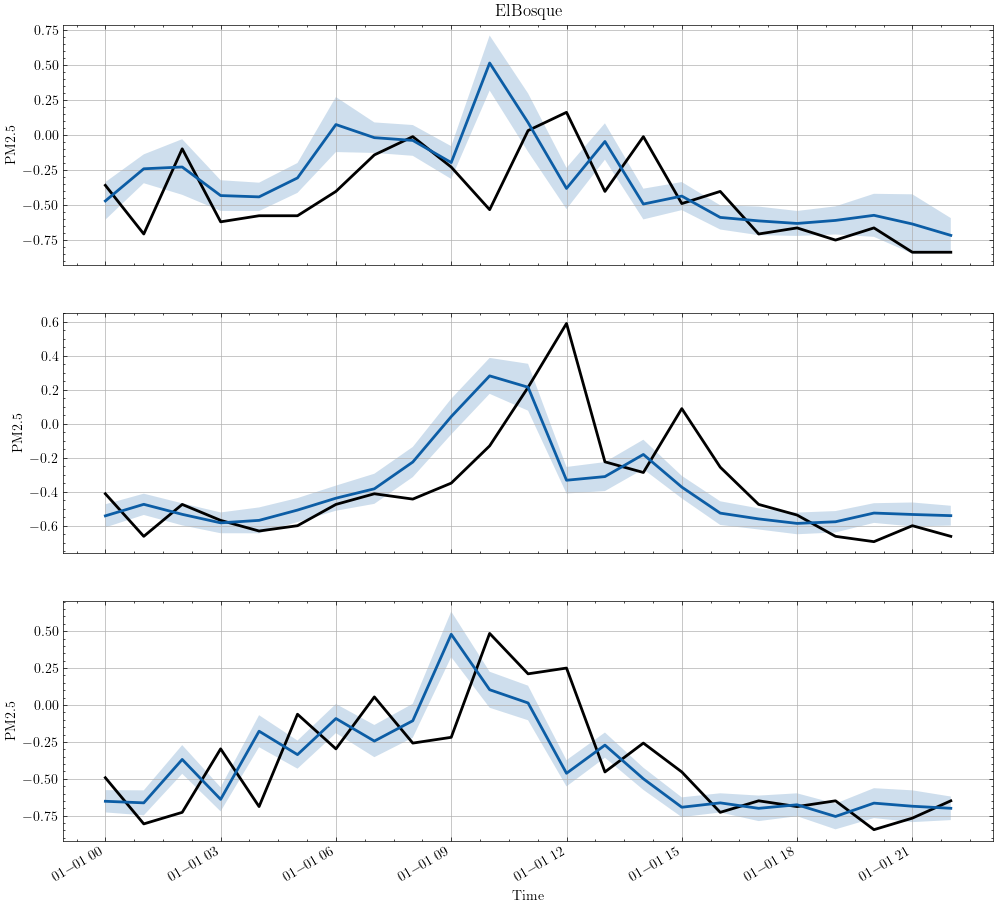

In [63]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 12))

future_pred=0
names=np.ravel(gdf.index[0:23].to_frame().values)
ax1.plot(names,y_test_datasets[0,:23,future_pred], linewidth=2,color="black")
ax1.plot(names,mean_pred[0,2:25,future_pred], linewidth=2)
ax1.fill_between(names,np.ravel(mean_pred[0,2:25,future_pred]-std_pred[0,2:25,future_pred]),np.ravel(mean_pred[0,2:25,future_pred]+std_pred[0,2:25,future_pred]),alpha=0.2)
ax1.set_xlabel('Time')
ax1.set_ylabel('PM2.5')
#ax1.legend(dataset_names[0], loc="upper left", fontsize="xx-large")
ax1.grid(True)

ax2.plot(names,y_test_datasets[1,:23,future_pred], linewidth=2,color="black")
ax2.plot(names,mean_pred[1,2:25,future_pred], linewidth=2)
ax2.fill_between(names,np.ravel(mean_pred[1,2:25,future_pred]-std_pred[1,2:25,future_pred]),np.ravel(mean_pred[1,2:25,future_pred]+std_pred[1,2:25,future_pred]),alpha=0.2)
ax2.set_xlabel('Time')
ax2.set_ylabel('PM2.5')
ax1.set_title(dataset_names[1])
ax2.grid(True)

ax3.plot(names,y_test_datasets[2,:23,future_pred], linewidth=2,color="black")
ax3.plot(names,mean_pred[2,2:25,future_pred], linewidth=2)
ax3.fill_between(names,np.ravel(mean_pred[2,2:25,future_pred]-std_pred[2,2:25,future_pred]),np.ravel(mean_pred[2,2:25,future_pred]+std_pred[2,2:25,future_pred]),alpha=0.2)
ax3.set_xlabel('Time')
ax3.set_ylabel('PM2.5')
ax1.set_title(dataset_names[2])
ax3.grid(True)

fig.autofmt_xdate()

In [174]:
import jaxlib 

jaxlib.__version__

'0.4.30'

In [175]:
import flax 

flax.__version__

'0.8.5'